In [58]:
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ibm = pd.read_csv("IBM.csv")
df_ibm.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
print(df_ibm.shape)

(3020, 7)


In [4]:
df_ibm.isnull().values.any()

True

In [5]:
# delete any null value in the data
df_ibm.dropna(inplace=True)
df_ibm.shape

(3019, 7)

In [8]:
df_ibm['Date'] = pd.to_datetime(df_ibm['Date'])
df_ibm.set_index('Date', inplace=True)
df_ibm.head() 

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


### Data Visualization

Text(0.5, 1.0, 'IBM High and Low')

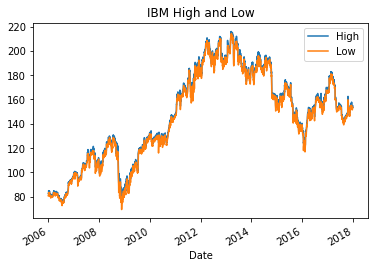

In [14]:
df_ibm[['High', 'Low']].plot()
plt.title('IBM High and Low')

Text(0.5, 1.0, 'IBM Open and Close')

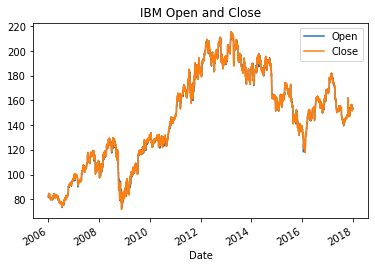

In [13]:
df_ibm[['Open', 'Close']].plot()
plt.title('IBM Open and Close')

We will be modeling the IBM stock open prices form the avaialble data.

## Auto-correlation Plot

Auto correlation plot with lag 1

Text(0.5, 1.0, 'IBM Autocorrelation plot - Lag 1')

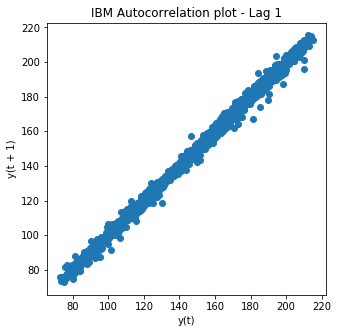

In [22]:
plt.figure(figsize=(5,5))
lag_plot(df_ibm.Open, lag=1)
plt.title('IBM Autocorrelation plot - Lag 1')

Text(0.5, 1.0, 'IBM Auto correlation Plot Lag - 5')

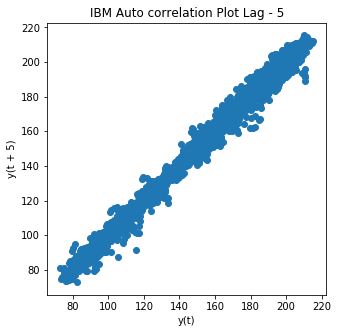

In [23]:
plt.figure(figsize=(5,5))
lag_plot(df_ibm.Open, lag=5)
plt.title('IBM Auto correlation Plot Lag - 5')

We see a linear trend in the auto-correlation plot hence there is some correlation in prices with respect to prices from previous 1 / 5 days of lag.

Split the data into test and train

In [25]:
train_data, test_data = df_ibm.iloc[0:int(len(df_ibm)*0.8), :], df_ibm.iloc[int(len(df_ibm)*0.8):, :]

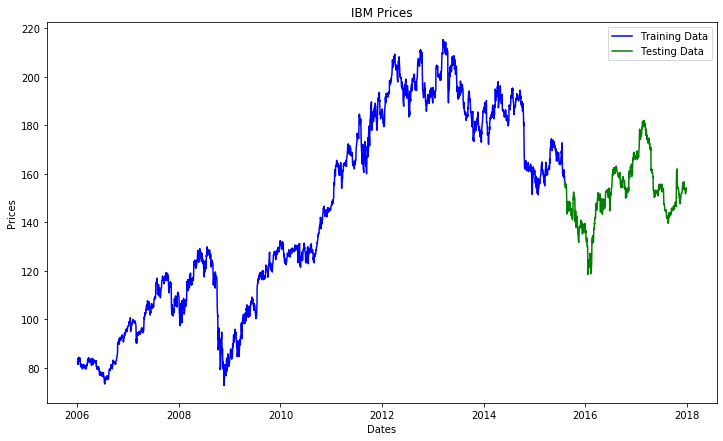

In [26]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

ADF test to find stationarity of the series. 

Lets first plot a graph for the rolling mean and standard deviation to check the stationarity of the series

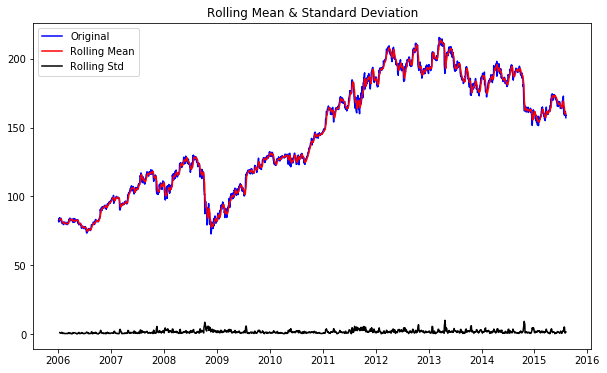

In [31]:
window = 7 #Rolling mean for 7 days
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

As we can see the rolling mean of our series is not contant and varies with the time our series is not stationary. 
Lets confirm our observation with ADF test.

In [32]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

In the above test we have a higher p-value of 0.53 hence our series is not stationary. 

We need to make the series stationary. Lets try by first order differencing in the series. 

In [33]:
train_diff = train_series.diff(periods=1)
train_diff = train_diff.dropna(inplace = False)

Rolling mean for the difference series

Text(0.5, 1.0, 'Differnce by 1 Rolling Mean & standard Deviation')

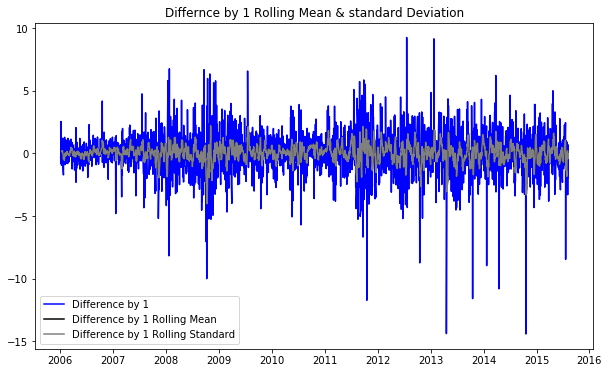

In [36]:
window = 7   #Rolling mean for 7 days
rollmean_diff = train_diff.rolling(window).mean()
roll_std_diff = train_diff.rolling(window).mean()

#Plot rolling statistics:
fig = plt.figure(figsize=(10,6))
plt.plot(train_diff, color='blue', label='Difference by 1')
plt.plot(rollmean_diff, color='black', label='Difference by 1 Rolling Mean')
plt.plot(roll_std_diff, color='grey', label='Difference by 1 Rolling Standard')
plt.legend(loc='best')
plt.title('Differnce by 1 Rolling Mean & standard Deviation')

As we can see the rolling mean and standard deviation of our series is contant and does not varies with the time. it seems our series is stationary. 
Lets confirm our observation with ADF test.

In [37]:
dftest_diff = adfuller(train_diff, autolag='AIC')
dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest_diff[4].items():
    dfoutput_diff['Critical Value (%s)'%key] = value
dfoutput_diff

Test Statistic                  -20.324277
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

After differencing, the p-value is extremely small. Thus this series is stationary.

### AIRMA Model

As by taking difference by 1 make our series hence d=1. 
Lets try to estimate p and q value for the ARIMA model. 

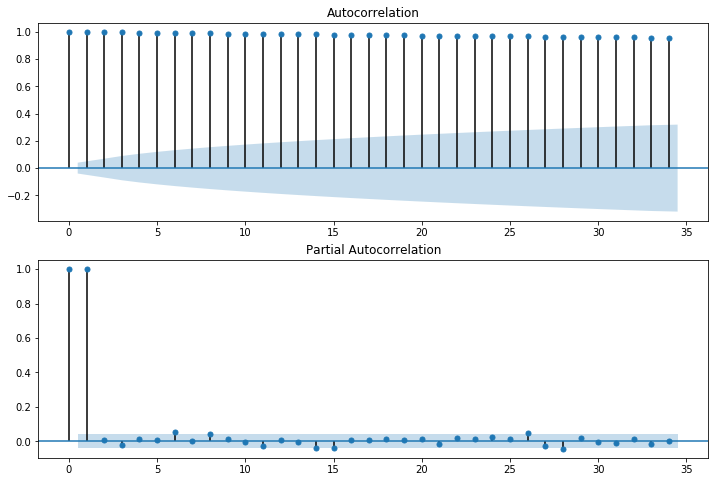

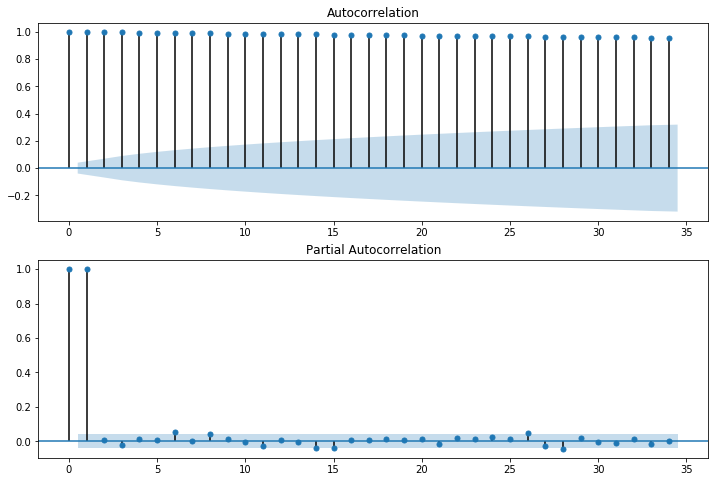

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0])  
plot_pacf(train_series, ax=ax[1])

AIC and PACF plot for Differenced series

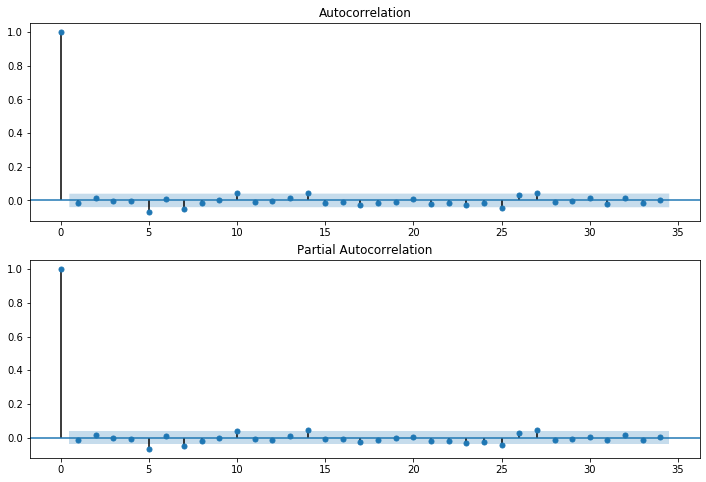

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

Form PACF we can say that with 5 lags the AR is significant. Which means, we can use AR = 5 i.e, p = 5 and there are very less significance spikes model hence q = 0

Hence:

p=5
d=1
q=0

In [60]:
test_series = test_data['Open']
test_diff = test_series.diff(periods=1)
test_diff = test_diff.dropna(inplace = False)

In [67]:

%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(train_diff, order=(5,1,0), ) # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model

    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

Wall time: 4min 22s


### Transform the forecasted values
As we have used differencing of the first order in the series for training hence we need to transfrom the values to get the meaningful forcase 

In [62]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((604,), (604,))

Lets calcualted the error on the predicted values

In [64]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 33270.685


Plotting the predicted and actual values

In [68]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

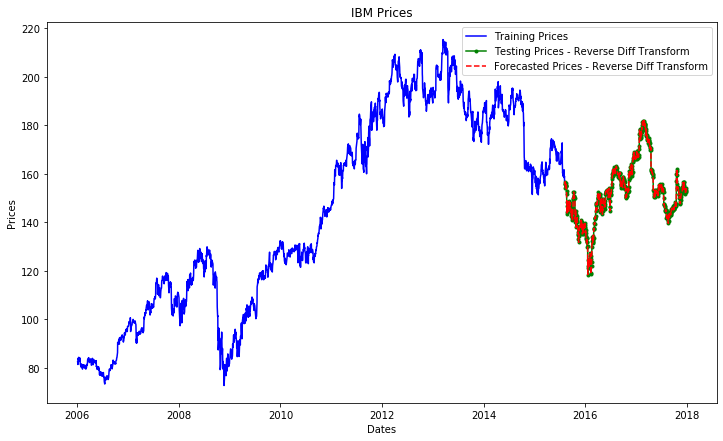

In [69]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();